In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cftime
#import cmaps
import cartopy
import cartopy.crs as ccrs
import sectionate
import intake
#!conda install -c conda-forge xmip
import xmip.preprocessing as xmip
#from xmip.preprocessing import rename_cmip6

from __future__ import print_function
import requests
import xml.etree.ElementTree as ET

import warnings

warnings.filterwarnings('ignore')

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
## Currently this all runs using files on esgf
# Eventually data will be loaded in from zarr files
# So will want to 

In [3]:
#!/usr/bin/env python

import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [4]:
## Load in file of model names and fnames
model_fnames_dict = np.load("../models.npy", allow_pickle=True).item()


In [5]:
### Set Bering Straight region 

bering_minlon = 190 #188 #172 #160
bering_maxlon = 192 #196 #200
#Note that most models are very sensitive to the maxlon value as most of the grids slant that way


lat_bs_i = 66 + (19.6/60) - 0.5

bs_lons = [bering_minlon, bering_maxlon]
bs_lats = [lat_bs_i, lat_bs_i]

In [6]:
def load_model_from_esgf_file_in_model_fnames_dict(model, model_fnames_dict) : 
    
    ## Generate filename from model_fnames_dict
    fnames_i = model_fnames_dict[model]

    # Open filenames
    ds_i = xr.open_mfdataset([fnames_i[0]], combine='by_coords', compat='override')

    #Sort out coords with xmip
    ds_i = xmip.rename_cmip6(ds_i)
    ds_i = xmip.promote_empty_dims(ds_i)
    ds_i = xmip.broadcast_lonlat(ds_i)
    ds_i = xmip.correct_lon(ds_i)
    ds_i = xmip.replace_x_y_nominal_lat_lon(ds_i)
    ds_i = xmip.correct_coordinates(ds_i)
    ds_i = xmip.parse_lon_lat_bounds(ds_i)
    ds_i = xmip.maybe_convert_bounds_to_vertex(ds_i)
    ds_i = xmip.maybe_convert_vertex_to_bounds(ds_i)
    
    
    ##Make lat and lon coords not vars
    #ds_i = ds_i.assign_coords({'lon':ds_i.lon, 'lat':ds_i.lat})
    
    ##Sort by lon 
    #ds_i = ds_i.sortby('lon')

    ## Subset by >50N
    cond_i = (ds_i['lat']>=50)
    dsnow = ds_i.where(cond_i,drop=True) #[[var_i]]
    
    
    return(dsnow)

In [7]:
def subset_model_by_lat_ind(dsnow_gt_bs_lat_i) : 
    #Calc all min and max x and y indexes
    yind1 = dsnow_gt_bs_lat_i.lat.isel(y=0).y.values
    yind2 = dsnow_gt_bs_lat_i.lat.isel(y=-1).y.values
    xind1 = dsnow_gt_bs_lat_i.lat.isel(x=0).x.values
    xind2 = dsnow_gt_bs_lat_i.lat.isel(x=-1).x.values

    ## Determine if x or y index corresponds to lat and if min or max index corresponds to lat

    y1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)
    y2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)

    x1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)
    x2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)

    # First test if lat range corresponding to xind or yind max-min is bigger
    if (y1_ind_diff < x1_ind_diff) & (y2_ind_diff < x2_ind_diff)  : 
        # If true then y ind corresponds to determining lat 
        # Ideally should test this for both x1 and x2 BUT should be same

        #Test if y1 or y2 corresponds to min lat
        if np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values) <= np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values) : 
            dsnow_bs_lat_i_ind = dsnow.sel(y=yind1) #dsnow_gt_bs_lat_i.sel(y=yind1)

        else : 
            print("y2 > y1")
            dsnow_bs_lat_i_ind = dsnow.sel(y=yind2) #dsnow_gt_bs_lat_i.sel(y=yind2)


    elif (y1_ind_diff > x1_ind_diff) & (y2_ind_diff > x2_ind_diff)  : 
        # If True then x ind corresponds to determining lat
        print('Note : x ind seems to correspond to lat not y (as expected)!')

        #Test if y1 or y2 corresponds to min lat
        if np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values) < np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values) : 
            dsnow_bs_lat_i_ind = dsnow.sel(x=xind1) #dsnow_gt_bs_lat_i.sel(x=xind1)

        else : 
            print("y2 > y1")
            dsnow_bs_lat_i_ind = dsnow.sel(x=xind2) #dsnow_gt_bs_lat_i.sel(x=xind2)

    else : 
        print("Something weird is going on - check what is happening. x1_ind_diff is : "+str(x1_ind_diff)+", x2_ind_diff is : "+str(x2_ind_diff)+"y1_ind_diff is : "+str(y1_ind_diff)+", y2_ind_diff is : "+str(y2_ind_diff))
        dsnow_bs_lat_i_ind = []
        
        
    return(dsnow_bs_lat_i_ind)

CMCC-CM2-SR5
NorESM2-LM
MRI-ESM2-0
CNRM-CM6-1
FGOALS-f3-L
CNRM-CM6-1-HR
TaiESM1-TIMCOM
CMCC-CM2-HR4
TaiESM1-TIMCOM2
ACCESS-OM2
EC-Earth3
ACCESS-OM2-025
MIROC6
CPU times: user 26.2 s, sys: 6.24 s, total: 32.4 s
Wall time: 12min 53s


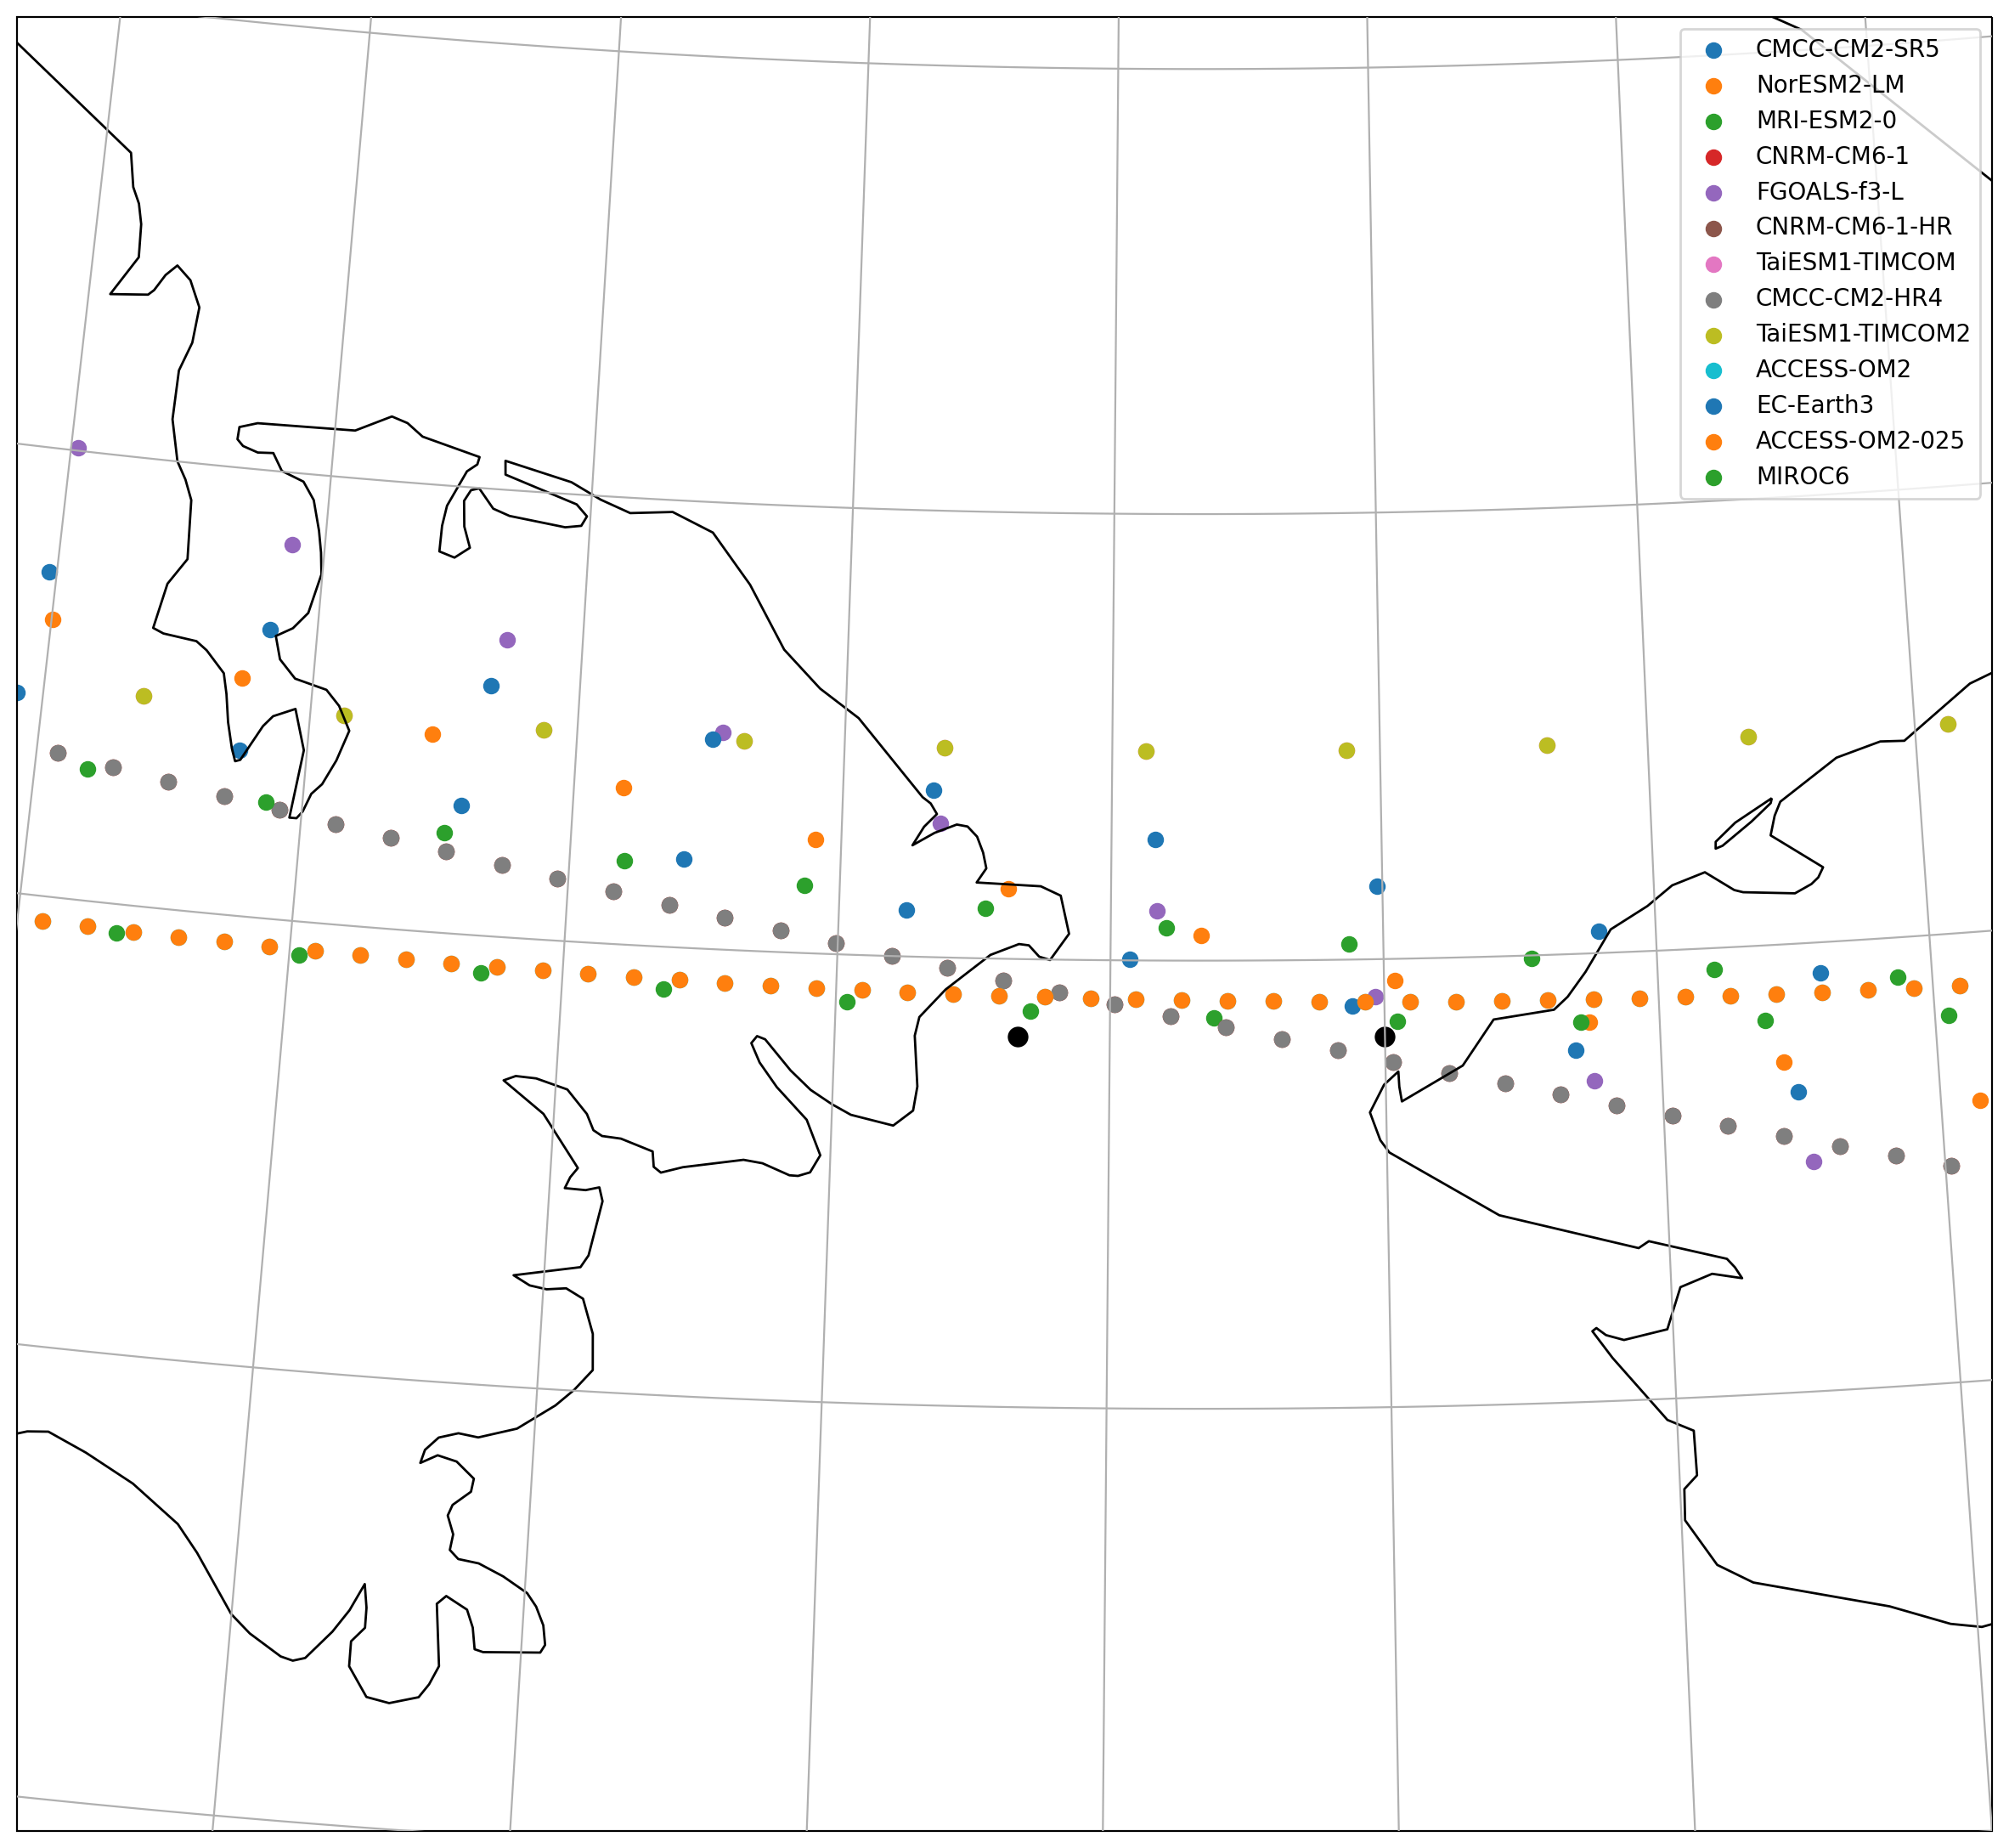

In [8]:
%%time 

## Loop through models and load in file, find lowest index then plot it

for model in model_fnames_dict : 
    print(model)

    #model = list(model_fnames_dict.keys())[0]

    try : 
        #Load dsnow using load_model_from_esgf_file_in_model_fnames_dict
        dsnow = load_model_from_esgf_file_in_model_fnames_dict(model, model_fnames_dict)


        #Subset by bs 
        cond_bs_lat_i = (dsnow['lat']>=lat_bs_i) & (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
        dsnow_gt_bs_lat_i = dsnow.where(cond_bs_lat_i ,drop=True) #[[var_i]]

        # Subset models by lat index
        dsnow_bs_lat_i_ind = subset_model_by_lat_ind(dsnow_gt_bs_lat_i)


        if model == list(model_fnames_dict.keys())[0] : 
            #First model so generate plot
            fig, axes = plt.subplots(nrows=1,  ncols=1, figsize=(15,15))
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.set_extent([185, 195, 64, 68], ccrs.PlateCarree()) #[160, 210, 50, 80], ccrs.PlateCarree())
            ax1.coastlines(resolution='50m',color='black', linewidth=1, zorder=3)
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)
            gl = ax1.gridlines(draw_labels=False, zorder=4)
            ax1.scatter(bs_lons[0], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=60)
            ax1.scatter(bs_lons[1], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=60)

        elif model == list(model_fnames_dict.keys())[-1] : 
            #Final model (plot legend and save plot)
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)        
            plt.legend()

            #Save fig 

        else :    
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)

    except : 
        print("Couldn't load : "+str(model))

In [45]:
#model
#model_fnames_dict[model]
#fnames_i #list(model_fnames_dict.keys())[0]


#ds1 = xr.open_dataset(model_fnames_dict[list(model_fnames_dict.keys())[0]][0])
#ds2 = xr.open_dataset(fnames_i[1])

#ds3 = xr.open_dataset(fnames_i[2])
#ds4 = xr.open_dataset(fnames_i[3])

#ds1 = rename_cmip6(ds1)

#ds1, ds2

#np.nanmin(ds1.vertices_latitude) , np.nanmin(ds2.vertices_latitude)
#np.nanmin(ds1.lon), np.nanmax(ds1.lon)

#ds12 = xr.open_mfdataset(fnames_i, combine='by_coords', compat='override')
#ds12

(0.049801330689206225, 359.99492450265325)

In [59]:
dsnow

<xarray.Dataset>
Dimensions:      (y: 294, x: 1442, vertex: 4, lev: 75, bnds: 2, time: 60)
Coordinates:
    lon          (y, x) float32 dask.array<chunksize=(294, 1442), meta=np.ndarray>
    lon_bounds   (y, x, vertex) float32 dask.array<chunksize=(294, 1442, 4), meta=np.ndarray>
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) object 1958-01-16 12:00:00 ... 1962-12-16 12:00:00
  * y            (y) float32 50.11 50.28 50.45 50.62 ... 89.79 89.89 89.95 90.0
  * x            (x) float64 0.25 0.5 0.75 1.0 2.75 ... 355.2 355.5 356.2 358.0
  * vertex       (vertex) int64 0 1 2 3
  * bnds         (bnds) int64 0 1
Data variables:
    lat          (y, x) float32 dask.array<chunksize=(294, 1442), meta=np.ndarray>
    lat_bounds   (y, x, vertex) float32 dask.array<chunksize=(294, 1442, 4), meta=np.ndarray>
    lev_bounds   (lev, bnds, y, x) float64 dask.array<chunksize=(75, 2, 294, 1442), meta=np.ndarray>
    time_bounds  (time, bnds, y, x) object dask.array<chunksize=(60, 2, 294, 1442), meta=np.ndarray>
    so           (time, lev, y, x) float32 dask.array<chunksize=(60, 75, 294, 1442), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2020-10-18T01:00:10Z
    description:                     Global ocean - sea-ice coupled experimen...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    activity_id:                     OMIP
    contact:                         contact.cmip@meteo.fr
    ...                              ...
    parent_source_id:                no parent
    parent_time_units:               no parent
    parent_variant_label:            no parent
    history:                         none
    tracking_id:                     hdl:21.14100/44928c11-4022-4118-879e-164...
    DODS_EXTRA.Unlimited_Dimension:  time

## Testing one model

In [9]:
#Testing "CNRM-CM6-1"

### Set Bering Straight region 

#bering_minlon = 190 #188 #172 #160
#bering_maxlon = 192 #196 #200
##Note that most models are very sensitive to the maxlon value as most of the grids slant that way


#lat_bs_i = 66 + (19.6/60) - 0.5

#bs_lons = [bering_minlon, bering_maxlon]
#bs_lats = [lat_bs_i, lat_bs_i]

model_name_des = "TaiESM1-TIMCOM2"

dsnow = load_model_from_esgf_file_in_model_fnames_dict(model_name_des, model_fnames_dict)

#Subset by bs 
cond_bs_lat_i = (dsnow['lat']>=lat_bs_i) & (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
dsnow_gt_bs_lat_i = dsnow.where(cond_bs_lat_i ,drop=True) #[[var_i]]

dsnow_bs_lat_i_ind = subset_model_by_lat_ind(dsnow_gt_bs_lat_i)

dsnow_bs_lat_i_ind

<xarray.Dataset>
Dimensions:        (time: 732, lev: 55, x: 320, bnds: 2, vertex: 4)
Coordinates: (12/14)
  * time           (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
  * lev            (lev) float64 5.501 16.7 28.18 ... 5.061e+03 5.542e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(55, 2), meta=np.ndarray>
    y              float64 66.47
  * x              (x) float64 0.5625 1.688 2.812 3.938 ... 357.2 358.3 359.4
    ...             ...
    lat            (x) float64 dask.array<chunksize=(320,), meta=np.ndarray>
    lon            (x) float64 dask.array<chunksize=(320,), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, x) float64 dask.array<chunksize=(1, 320), meta=np.ndarray>
    lat_bounds     (bnds, x) float64 dask.array<chunksize=(1, 320), meta=np.ndarray>
Data variables:
    so             (time, lev, x) float32 dask.array<chunksize=(732, 55, 320), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     OMIP
    branch_method:                   no parent
    contact:                         Dr. Yu-Heng Tseng (tsengyh@ntu.edu.tw)
    creation_date:                   2021-12-15T07:47:07Z
    data_specs_version:              01.00.33
    ...                              ...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by REQUIRED is...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/37b45ca4-b20f-47bb-9ea0-509...
    DODS_EXTRA.Unlimited_Dimension:  time

In [13]:
dsnow_gt_bs_lat_i.lat.values, dsnow_gt_bs_lat_i.lon.values

(array([[66.46869684, 66.46869684],
        [67.24511196, 67.24511196],
        [68.02618557, 68.02618557],
        [68.81194562, 68.81194562],
        [69.60242023, 69.60242023],
        [70.39763769, 70.39763769],
        [71.19762646, 71.19762646],
        [72.00241515, 72.00241515],
        [72.81203258, 72.81203258],
        [73.62650771, 73.62650771],
        [74.4458697 , 74.4458697 ],
        [75.27014785, 75.27014785],
        [76.09937168, 76.09937168],
        [76.93357084, 76.93357084],
        [77.77277521, 77.77277521],
        [78.6170148 , 78.6170148 ],
        [79.46631982, 79.46631982],
        [80.32072068, 80.32072068],
        [81.18024794, 81.18024794],
        [82.04493236, 82.04493236],
        [82.9148049 , 82.9148049 ],
        [83.78989666, 83.78989666],
        [84.67023898, 84.67023898],
        [85.55586335, 85.55586335]]),
 array([[190.6875, 191.8125],
        [190.6875, 191.8125],
        [190.6875, 191.8125],
        [190.6875, 191.8125],
        [190.6

In [20]:
dsnow_gt_bs_lat_i.isel(time=0).isel(lev=0).so.values #.plot()

RuntimeError: NetCDF: Authorization failure

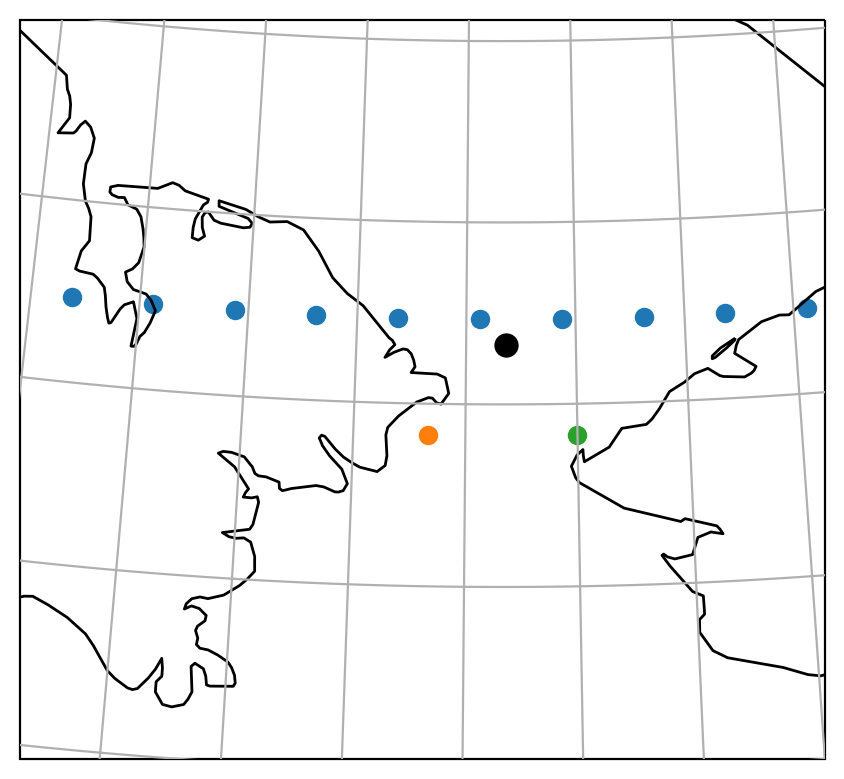

In [10]:
ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))

ax1.set_extent([185, 195, 64, 68], ccrs.PlateCarree()) #[160, 210, 50, 80], ccrs.PlateCarree())

ax1.coastlines(resolution='50m',color='black', linewidth=1, zorder=3)
#ax1.add_feature(cartopy.feature.LAND, facecolor='lightgrey', zorder=2)


ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.RIVERS, edgecolor='royalblue', zorder=3)

#if len(dsnow_bs_trans_j.lon)>1 : 
#    ax1.scatter(dsnow_bs_trans_j.lon, dsnow_bs_trans_j.lat, transform=ccrs.PlateCarree()) #scatter
#else : 
#    ax1.scatter(dsnow_bs_trans_j.lon, np.ones(len(dsnow_bs_trans_j.lon))*dsnow_bs_trans_j.lat.values, transform=ccrs.PlateCarree()) #scatter

gl = ax1.gridlines(draw_labels=False, zorder=4)
ax1.scatter(bs_lons[0], lat_bs_i, transform=ccrs.PlateCarree())
ax1.scatter(bs_lons[1], lat_bs_i, transform=ccrs.PlateCarree())

ax1.scatter([180 + (180-168 - 57.5/60)], [66 + (19.6/60)], transform=ccrs.PlateCarree(), c='k', s=60)

#ax1.pcolormesh()

#dsnow_bs.so.plot()

In [69]:
#dsnow.where((dsnow['lon']>=bering_minlon), drop=True) #& (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
#np.nanmin(dsnow.lon), np.nanmax(dsnow.lon)
#np.nanmax(dsnow.lat.values) #_gt_bs_lat_i

## Old Code

In [ ]:
%%time 

## Loop through models and load in file, find lowest index then plot it

for model in model_fnames_dict : 
    print(model)

    #model = list(model_fnames_dict.keys())[0]

    try : 
        #Load dsnow using load_model_from_esgf_file_in_model_fnames_dict
        dsnow = load_model_from_esgf_file_in_model_fnames_dict(model, model_fnames_dict)

        ### Generate filename from model_fnames_dict
        #fnames_i = model_fnames_dict[model]
        ## Open filenames
        #ds_i = xr.open_mfdataset(fnames_i, combine='by_coords', compat='override')
        ##Sort out coords with xmip
        #ds_i = rename_cmip6(ds_i)
        ##Make lat and lon coords not vars
        #ds_i = ds_i.assign_coords({'lon':ds_i.lon, 'lat':ds_i.lat})
        ### Subset by >50N
        #cond_i = (ds_i['lat']>=50)
        #dsnow = ds_i.where(cond_i,drop=True) #[[var_i]]

        #Subset by bs 
        cond_bs_lat_i = (dsnow['lat']>=lat_bs_i) & (dsnow['lon']>=bering_minlon) & (dsnow['lon']<=bering_maxlon)
        dsnow_gt_bs_lat_i = dsnow.where(cond_bs_lat_i ,drop=True) #[[var_i]]

        
        dsnow_bs_lat_i_ind = subset_model_by_lat_ind(dsnow_gt_bs_lat_i)
        ##Calc all min and max x and y indexes
        #yind1 = dsnow_gt_bs_lat_i.lat.isel(y=0).y.values
        #yind2 = dsnow_gt_bs_lat_i.lat.isel(y=-1).y.values
        #xind1 = dsnow_gt_bs_lat_i.lat.isel(x=0).x.values
        #xind2 = dsnow_gt_bs_lat_i.lat.isel(x=-1).x.values

        ### Determine if x or y index corresponds to lat and if min or max index corresponds to lat

        #y1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values)
        #y2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values)

        #x1_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values)
        #x2_ind_diff = np.nanmax(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)-np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values)

        ## First test if lat range corresponding to xind or yind max-min is bigger
        #if (y1_ind_diff < x1_ind_diff) & (y2_ind_diff < x2_ind_diff)  : 
        #    # If true then y ind corresponds to determining lat 
        #    # Ideally should test this for both x1 and x2 BUT should be same

        #    #Test if y1 or y2 corresponds to min lat
        #    if np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind1).values) <= np.nanmin(dsnow_gt_bs_lat_i.lat.sel(y=yind2).values) : 
        #        dsnow_bs_lat_i_ind = dsnow_gt_bs_lat_i.sel(y=yind1)

         #   else : 
         #       print("y2 > y1")
         #       dsnow_bs_lat_i_ind = dsnow_gt_bs_lat_i.sel(y=yind2)


        #elif (y1_ind_diff > x1_ind_diff) & (y2_ind_diff > x2_ind_diff)  : 
        #    # If True then x ind corresponds to determining lat
        #    print('Note : x ind seems to correspond to lat not y (as expected)!')

         #   #Test if y1 or y2 corresponds to min lat
         #   if np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind1).values) < np.nanmin(dsnow_gt_bs_lat_i.lat.sel(x=xind2).values) : 
         #       dsnow_bs_lat_i_ind = dsnow_gt_bs_lat_i.sel(x=xind1)

          #  else : 
          #      print("y2 > y1")
          #      dsnow_bs_lat_i_ind = dsnow_gt_bs_lat_i.sel(x=xind2)

        #else : 
        #    print("Something weird is going on - check what is happening. x1_ind_diff is : "+str(x1_ind_diff)+", x2_ind_diff is : "+str(x2_ind_diff)+"y1_ind_diff is : "+str(y1_ind_diff)+", y2_ind_diff is : "+str(y2_ind_diff))



        if model == list(model_fnames_dict.keys())[0] : 
            #First model so generate plot
            fig, axes = plt.subplots(nrows=1,  ncols=1, figsize=(15,15))
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.set_extent([185, 195, 64, 68], ccrs.PlateCarree()) #[160, 210, 50, 80], ccrs.PlateCarree())
            ax1.coastlines(resolution='50m',color='black', linewidth=1, zorder=3)
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)
            gl = ax1.gridlines(draw_labels=False, zorder=4)
            ax1.scatter(bs_lons[0], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=60)
            ax1.scatter(bs_lons[1], lat_bs_i, transform=ccrs.PlateCarree(), c='k', s=60)

        elif model == list(model_fnames_dict.keys())[-1] : 
            #Final model (plot legend and save plot)
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)        
            plt.legend()

            #Save fig 

        else :    
            ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=(bs_lons[0]+bs_lons[1])/2))
            ax1.scatter(dsnow_bs_lat_i_ind.lon, dsnow_bs_lat_i_ind.lat, transform=ccrs.PlateCarree(), label=model)

    except : 
        print("Couldn't load : "+str(model))

CMCC-CM2-SR5
NorESM2-LM
